### study1_answer_task_train_and_eval_v0.1
- 最終更新: 2023/7/25, 9:05

- 研究1: 回答学種モデル/課題含む（案1）

- 「目的案1. 日本語版SSTの自動採点モデルの有効性調査」
  - 意図: モデルを<u>SSTのみ</u>に適用する状況での精度評価
  - 方法: 予備調査の採点結果で学習・評価（研究1）→研究1のモデルで本調査aの項目の一部を評価(研究2)
    - 20項目全ての採点基準表/過去データをもとに分析
    - 例: テストデータ/訓練データともに「飛行機-鳥」を含む（同一の回答は含まれないが）
    
  - 示唆: 日本語版SSTで学習したモデルがどれくらい日本語版SSTの自動採点において有効かを定量評価できる。

#### Google Driveのマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!python --version

Python 3.10.12


#### 環境構築

aptやらpipやらの下準備
- 参考: https://qiita.com/karaage0703/items/30485c2ba1c396760982

In [ ]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7
!pip install fugashi ipadic unidic-lite
!pip install scikit-learn

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcwidget4 libsigc++-2.0-0v5 libxapian30
Suggested packages:
  apt-xapian-index aptitude-doc-en | aptitude-doc debtags tasksel
  libcwidget-dev xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcwidget4 libsigc++-2.0-0v5 libxapian30
0 upgraded, 5 newly installed, 0 to remove and 8 not upgraded.
Need to get 3,838 kB of archives.
After this operation, 17.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 aptitude-common all 0.8.13-3ubuntu1 [1,719 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsigc++-2.0-0v5 amd64 2.10.4-2ubuntu3 [12.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcwidget4 amd64 0.5.18-5build1 [306 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libxapian30 amd64 

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.4 MB/s eta 0:00:00


In [ ]:
#transformersの準備
!pip install transformers[torch] neologdn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 25.8 MB/s eta 0:00:00
  Created wheel for neologdn: filename=neologdn-0.5.1-cp310-cp310-linux_x86_64.whl size=182991 sha256=b15b6204f148e61871593f7428841a1e95a97ff9fce0a4c13d4bc890285d0fee
  Stored in directory: /root/.cache/pip/wheels/9d/19/20/8db53d94dea31481e7b7a66ca4ed9f6a8e20e349471a2796f2
Successfully built neologdn


In [ ]:
pip install accelerate -U

In [ ]:
#GPUの認識状況の確認
!nvidia-smi

Tue Jul 25 00:11:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### 以下はコード

##### データの準備
- v0.2までは`data_basic`を使っていた（train/test splitのみ実施）


In [ ]:
#ライブラリのインポート
import numpy as np
import pandas as pd
import tqdm

In [ ]:
#データの読み込み
data = pd.read_csv("/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/data/20230213_PreExp_SST_ClassifyAnswer_v5.1.csv")
data.head()

,order,trial_index,time_elapsed,cwid,StartTime,EndTime,rt,word_pair,answer,SHに基づく得点,SH：補足,PickedSample,Classification_ksm,Classification_oka,ageement,CR_ksm,CR_oka,FinalRating,Note_ksm,Note_oka
0,1,2,33223,275026,44928.9242,44928.92715,15459,鳥 - 飛行機,とぶもの,2,NaN,1,2.0,2,1.0,NaN,NaN,2,NaN,NaN
1,2,3,41046,275026,44928.9242,44928.92715,7810,剣 - 拳銃,攻撃するもの,1,攻撃するという共通点だけ,0,NaN,1,NaN,NaN,NaN,1,NaN,NaN
2,3,4,50740,275026,44928.9242,44928.92715,9687,みかん - ボール,球状,2,球状は球形の同義語,0,NaN,2,NaN,NaN,NaN,2,NaN,NaN
3,4,5,55109,275026,44928.9242,44928.92715,4346,太陽 - 電球,光る,2,NaN,0,NaN,2,NaN,NaN,NaN,2,NaN,NaN
4,5,6,60701,275026,44928.9242,44928.92715,5565,紙 - 葉っぱ,平たい,1,平たいシートである点がポイント、平たいは低次の共通点,0,NaN,1,NaN,NaN,NaN,1,NaN,NaN


In [ ]:
#trial_indexで以下を除外
#Oka, Utsumi, & Kusumi (under review)では項目選定の都合で以下の項目についても利用していたが、最終的には利用しなかった。
#詳細はhttps://github.com/okaexp/Japanese_version_of_SST

#12: 孤独-砂漠
#20: 鍵-答え
#23: 学位-橋
#25: 若者-鳥

data = data[~data["trial_index"].isin([12, 20, 23, 25])]
print(data.trial_index.unique())
print(data.word_pair.unique())
print(len(data.trial_index.unique()))

[ 2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 21 22 24]
['鳥 - 飛行機' '剣 - 拳銃' 'みかん - ボール' '太陽 - 電球' '紙 - 葉っぱ' '山頂 - 針' '道 - 川'
 '愛 - 薬物' '山 - 障害物' '輪っか - ネックレス' 'なぞなぞ - 迷宮' '時間 - 川' '会社 - 木' '酒場 - 教会'
 '理論 - 建物' 'ダイヤモンド - 雪片' '記憶 - 牢獄' '結婚 - 合金' '思考 - 網' '美術館 - 墓']
20


In [ ]:
#単語1, 単語2, 参加者の回答, 回答に対するlabels(FianlRatingの名前をlabelsとした)
data_basic = data.loc[:, ["word_pair", "answer", "FinalRating"]]
data_basic = pd.concat([data_basic, data_basic['word_pair'].str.split('-', expand=True)], axis=1).drop('word_pair', axis=1)
data_basic = data_basic.rename(columns={0: 'word1', 1: 'word2', "FinalRating": "labels"})
data_basic = data_basic.reindex(columns=["word1", "word2", "answer", "labels"])
data_basic

,word1,word2,answer,labels
0,鳥,飛行機,とぶもの,2
1,剣,拳銃,攻撃するもの,1
2,みかん,ボール,球状,2
3,太陽,電球,光る,2
4,紙,葉っぱ,平たい,1
...,...,...,...,...
1912,ダイヤモンド,雪片,美しい,1
1913,記憶,牢獄,覚える,0
1915,結婚,合金,合わせる,2
1916,思考,網,アメーバ状,2


In [ ]:
#data_basicからユニークな回答（word1ごとのanswerをユニークにする）を抽出する
#重複する回答はモデル学習/評価時にリークする恐れがあるため除外する
#ref: https://tiruka.hatenablog.jp/entry/2018/09/07/120553
data_basic_unique = data_basic.drop_duplicates(subset=['word1', 'word2', 'answer', 'labels'], keep='first')
data_basic_unique

,word1,word2,answer,labels
0,鳥,飛行機,とぶもの,2
1,剣,拳銃,攻撃するもの,1
2,みかん,ボール,球状,2
3,太陽,電球,光る,2
4,紙,葉っぱ,平たい,1
...,...,...,...,...
1910,酒場,教会,のめり込む,1
1911,理論,建物,硬い,1
1913,記憶,牢獄,覚える,0
1916,思考,網,アメーバ状,2


In [ ]:
#入力に使うtextを準備
#単語1[SEP]単語2[SEP]回答となるように整形
data_basic_unique["text"] = data_basic_unique['word1'] + "[SEP]" + data_basic_unique["word2"] + "[SEP]" + data_basic_unique["answer"]
data_basic_unique.head(11)

<ipython-input-12-dcc09402d818>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_basic_unique["text"] = data_basic_unique['word1'] + "[SEP]" + data_basic_unique["word2"] + "[SEP]" + data_basic_unique["answer"]


,word1,word2,answer,labels,text
0,鳥,飛行機,とぶもの,2,鳥 [SEP] 飛行機[SEP]とぶもの
1,剣,拳銃,攻撃するもの,1,剣 [SEP] 拳銃[SEP]攻撃するもの
2,みかん,ボール,球状,2,みかん [SEP] ボール[SEP]球状
3,太陽,電球,光る,2,太陽 [SEP] 電球[SEP]光る
4,紙,葉っぱ,平たい,1,紙 [SEP] 葉っぱ[SEP]平たい
5,山頂,針,尖っている,2,山頂 [SEP] 針[SEP]尖っている
6,道,川,筋になっている,1,道 [SEP] 川[SEP]筋になっている
7,愛,薬物,夢中になる,2,愛 [SEP] 薬物[SEP]夢中になる
8,山,障害物,困難さ,1,山 [SEP] 障害物[SEP]困難さ
9,輪っか,ネックレス,和状,0,輪っか [SEP] ネックレス[SEP]和状


In [ ]:
#インデックスのふりなおし
#ref: https://note.nkmk.me/python-pandas-reset-index/
data_basic_unique_reset_index = data_basic_unique.reset_index()
data_basic_unique_reset_index.head(11)

,index,word1,word2,answer,labels,text
0,0,鳥,飛行機,とぶもの,2,鳥 [SEP] 飛行機[SEP]とぶもの
1,1,剣,拳銃,攻撃するもの,1,剣 [SEP] 拳銃[SEP]攻撃するもの
2,2,みかん,ボール,球状,2,みかん [SEP] ボール[SEP]球状
3,3,太陽,電球,光る,2,太陽 [SEP] 電球[SEP]光る
4,4,紙,葉っぱ,平たい,1,紙 [SEP] 葉っぱ[SEP]平たい
5,5,山頂,針,尖っている,2,山頂 [SEP] 針[SEP]尖っている
6,6,道,川,筋になっている,1,道 [SEP] 川[SEP]筋になっている
7,7,愛,薬物,夢中になる,2,愛 [SEP] 薬物[SEP]夢中になる
8,8,山,障害物,困難さ,1,山 [SEP] 障害物[SEP]困難さ
9,9,輪っか,ネックレス,和状,0,輪っか [SEP] ネックレス[SEP]和状


### 訓練データとテストデータの分割
- 追記: 2023/7/21, 18:20
- 訓練データと評価データがそれぞれ必ず課題を含むことを確認
  - `sst_auto_scoring_learning_model_base_v0.3`以前の実装で上記を確認
- k-foldのkが大きいと分割がうまくいかないので、5-foldでやるか

In [ ]:
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
NUM_FOLDS = 5
RANDOM_STATE = 42

def create_stratifiedkfolds(df):
  """
  stratified k foldされたデータセットを返す関数を書く
  ref: https://www.kaggle.com/code/abhishek/step-1-create-folds/notebook
  """
  # we create a new column called kfold and fill it with -1
  df["kFold"] = -1

  # calculate number of bins by Sturge's rule
  # I take the floor of the value, you can also
  # just round it
  num_bins = int(np.floor(1 + np.log2(len(df))))

  # bin targets
  df.loc[:, "bins"] = pd.cut(
      df["labels"], bins=num_bins, labels=False
  )

  # initiate the kfold class from model_selection module
  kf = model_selection.StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_STATE)

  # fill the new kfold column
  # note that, instead of targets, we use bins!
  for f, (t_, v_) in enumerate(kf.split(X=df, y=df.bins.values)):
      df.loc[v_, 'kFold'] = f

  # drop the bins column
  df = df.drop("bins", axis=1)

  return df

In [ ]:
data_basic_unique_with_folds = create_stratifiedkfolds(data_basic_unique_reset_index)
data_basic_unique_with_folds

,index,word1,word2,answer,labels,text,kFold
0,0,鳥,飛行機,とぶもの,2,鳥 [SEP] 飛行機[SEP]とぶもの,1
1,1,剣,拳銃,攻撃するもの,1,剣 [SEP] 拳銃[SEP]攻撃するもの,2
2,2,みかん,ボール,球状,2,みかん [SEP] ボール[SEP]球状,0
3,3,太陽,電球,光る,2,太陽 [SEP] 電球[SEP]光る,4
4,4,紙,葉っぱ,平たい,1,紙 [SEP] 葉っぱ[SEP]平たい,0
...,...,...,...,...,...,...,...
1214,1910,酒場,教会,のめり込む,1,酒場 [SEP] 教会[SEP]のめり込む,4
1215,1911,理論,建物,硬い,1,理論 [SEP] 建物[SEP]硬い,0
1216,1913,記憶,牢獄,覚える,0,記憶 [SEP] 牢獄[SEP]覚える,3
1217,1916,思考,網,アメーバ状,2,思考 [SEP] 網[SEP]アメーバ状,0


In [ ]:
data_basic_unique_with_folds.value_counts(subset=["labels", "kFold"])

labels  kFold
1       0        118
        4        118
        1        117
        2        117
        3        117
2       0        110
        1        110
        2        110
        3        110
        4        109
0       1         17
        2         17
        3         17
        0         16
        4         16
dtype: int64

In [ ]:
#中身の確認
dk1 = data_basic_unique_with_folds.query('kFold == 0.0')
dk2 = data_basic_unique_with_folds.query('kFold == 1.0')
dk3 = data_basic_unique_with_folds.query('kFold == 2.0')
dk4 = data_basic_unique_with_folds.query('kFold == 3.0')
dk5 = data_basic_unique_with_folds.query('kFold == 4.0')

In [ ]:
#5-foldであればtrain-testともに一定量のラベルを含められる
print(dk1.word1.unique())
print(dk2.word1.unique())
print(dk3.word1.unique())
print(dk4.word1.unique())
print(dk5.word1.unique())

#全部含むか確認→含む
print(len(dk1.word1.unique()))
print(len(dk2.word1.unique()))
print(len(dk3.word1.unique()))
print(len(dk4.word1.unique()))
print(len(dk5.word1.unique()))

['みかん ' '紙 ' '山頂 ' '輪っか ' '時間 ' '思考 ' '鳥 ' '山 ' 'なぞなぞ ' '会社 ' '理論 ' '結婚 '
 '道 ' 'ダイヤモンド ' '記憶 ' '剣 ' '酒場 ' '愛 ' '美術館 ' '太陽 ']
['鳥 ' '理論 ' '結婚 ' '紙 ' '道 ' '山 ' 'なぞなぞ ' '思考 ' 'みかん ' '酒場 ' '太陽 ' '輪っか '
 '会社 ' '剣 ' '時間 ' '美術館 ' '愛 ' '山頂 ' 'ダイヤモンド ' '記憶 ']
['剣 ' '会社 ' 'ダイヤモンド ' 'みかん ' '太陽 ' '愛 ' '理論 ' '鳥 ' 'なぞなぞ ' '美術館 ' '道 '
 '山頂 ' '記憶 ' '時間 ' '思考 ' '結婚 ' '輪っか ' '酒場 ' '山 ' '紙 ']
['酒場 ' '記憶 ' 'ダイヤモンド ' '思考 ' '愛 ' '剣 ' '紙 ' '時間 ' 'なぞなぞ ' '理論 ' '鳥 '
 'みかん ' '会社 ' '山頂 ' '山 ' '美術館 ' '輪っか ' '太陽 ' '結婚 ' '道 ']
['太陽 ' '道 ' '愛 ' '山 ' 'なぞなぞ ' '美術館 ' '剣 ' '記憶 ' '山頂 ' '輪っか ' '結婚 ' '会社 '
 '思考 ' 'ダイヤモンド ' '理論 ' '紙 ' '時間 ' '酒場 ' '鳥 ' 'みかん ']
20
20
20
20
20


#### data_basicをdatasetに変換する

##### 準備に必要な関数群
- 以下は, v0.3からのkfoldする場合にdatasetに変換する方法->この部分はtrainerとかと一緒にfor文で回した方が良いか
- create_dataset: データセットを作成する関数
  - `data_basic_unique_with_folds`から学習データと評価データを分けて用意する
  - ref: https://www.philschmid.de/k-fold-as-cross-validation-with-a-bert-text-classification-example
- compute_metrics：評価指標の計算に用いるやつ
- CustomTrainer: 重みをそれぞれ変えるtrainerの設定に必要なやつ
- load_config: wiehgt_allとlogging_stepsを求めるのに必要なやつ

In [ ]:
import torch
from torch import nn
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from transformers import AdamW

#cudaを使う準備
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [ ]:
#乱数のseedを全固定する
#ref: https://qiita.com/ku_a_i/items/bac3befedbadab45774f
import random
import os

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

#乱数の決定
seed_everything(RANDOM_STATE)

from datasets import Dataset
def create_dataset(data_all):
  """
  dataset（pandasのデータフレーム）をtorchで使えるデータセットにする
  """

  def tokenize_basic(batch):
      return tokenizer(batch["text"], padding=True, truncation=True)

  #datasetをtrainとtestに分ける
  #ref: https://www.ai-shift.co.jp/techblog/2138
  data_train = data_all.query("kFold != @CUR_FOLD_IDX")
  data_test = data_all.query("kFold == @CUR_FOLD_IDX")
  #データセットのインデックスのふりなおし
  data_train = data_train.reset_index()
  data_test = data_test.reset_index()

  dataset_train = Dataset.from_pandas(data_train)
  dataset_test = Dataset.from_pandas(data_test)

  #datasetの雛形を元に[CLS]【単語1】[SEP]【単語2】[SEP]【参加者の回答】[SEP]とを用意
  dataset_train_encoded = dataset_train.map(tokenize_basic, batched=True, batch_size=None)
  dataset_test_encoded = dataset_test.map(tokenize_basic, batched=True, batch_size=None)

  return dataset_train_encoded, dataset_test_encoded, data_train, data_test


# メトリクスの定義
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#Trainerの重みを変えるやつ
#imbalanced dataのlossの定義
#ref: https://huggingface.co/docs/transformers/main/main_classes/trainer
#ref: https://dev.classmethod.jp/articles/huggingface-usage-custom-loss-func/
from transformers import TrainingArguments
from transformers import Trainer
from transformers import EarlyStoppingCallback
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        #2023/4/6: debug
        # print("compute_loss: labels, logits", labels, logits)
        # print("compute_loss: outputs: ", outputs)

        # compute custom loss (suppose one has 3 labels with different weights)
        # 訓練データの正例の逆数で重み付け
        loss_fct = nn.CrossEntropyLoss(weight=cur_config["weight_all"])
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        #print()
        # print("loss_fct: ", loss_fct)
        # print("loss: ", loss)

        return (loss, outputs) if return_outputs else loss

def load_bert_model_and_tokenizer():
  """
  BERTのモデルとトークナイザを呼び出す関数
  ※都度初期化して呼び出したいため、ここで呼ぶ
  """

  model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
  model = model.to(device)
  tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

  return model, tokenizer


class load_config:
  """
  cur_fold_idxを引数として、そのfoldにおけるlogging_stepsとweight_allを受け取る
  """
  #初期化
  def __init__(self, cur_fold_idx):
    self.cur_fold_idx = cur_fold_idx
    self.config = dict()

  def create_logging_steps(self):
    self.config["logging_steps"] = len(data_basic_unique_with_folds.query("kFold != @self.cur_fold_idx")) // BATCH_SIZE

  def create_weight_all(self):
    """
    weight_allを計算する
    ref: https://dev.classmethod.jp/articles/huggingface-usage-custom-loss-func/
    ref_conc: weight_all = torch.tensor([len(data_basic_unique_train)/75, len(data_basic_unique_train)/528, len(data_basic_unique_train)/494]).clone().to(device, torch.float32)
    """
    self.config["weight_all"] = torch.tensor([len(data_basic_unique_with_folds.query("kFold != @self.cur_fold_idx")) /len(data_basic_unique_with_folds.query("kFold !=@self.cur_fold_idx & labels== 0")),
                                            len(data_basic_unique_with_folds.query("kFold != @self.cur_fold_idx")) /len(data_basic_unique_with_folds.query("kFold !=@self.cur_fold_idx & labels== 1")),
                                            len(data_basic_unique_with_folds.query("kFold != @self.cur_fold_idx")) /len(data_basic_unique_with_folds.query("kFold !=@self.cur_fold_idx & labels== 2"))]).clone().to(device, torch.float32)

  def return_config(self):
    self.create_logging_steps()
    self.create_weight_all()
    return self.config

#結果の評価
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
def plot_confusion_matrix(y_preds, y_true, output_dir):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.savefig(output_dir+"confusion_matrix.png")
    plt.show()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertJapaneseTokenizer'. 
The class this function is called from is 'BertTokenizer'.


Map:   0%|          | 0/975 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/244 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.059300,0.975884,0.586066,0.575617
2,0.896400,0.885695,0.651639,0.654405
3,0.715500,0.829634,0.696721,0.701943
4,0.525600,0.892353,0.696721,0.695177
5,0.422800,0.774454,0.745902,0.755912
6,0.331500,0.852676,0.745902,0.749831
7,0.245500,1.028959,0.713115,0.709827
8,0.212000,1.029248,0.758197,0.758498


best model:  /content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/study1/study1_answer_task_train_and_eval_0/checkpoint-155


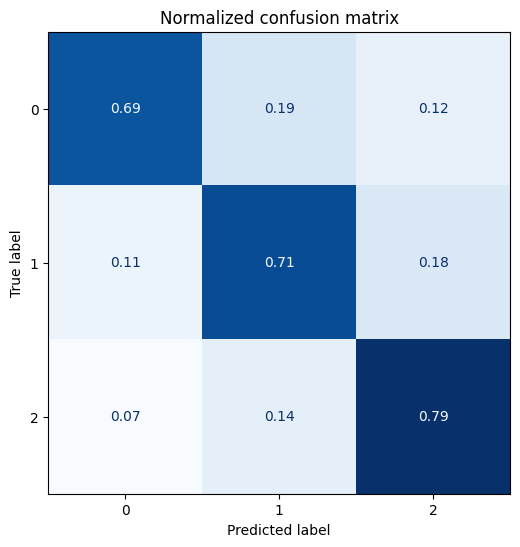

              precision    recall  f1-score   support

           2       0.34      0.69      0.46        16
           1       0.82      0.71      0.76       118
           0       0.79      0.79      0.79       110

    accuracy                           0.75       244
   macro avg       0.65      0.73      0.67       244
weighted avg       0.78      0.75      0.76       244



Map:   0%|          | 0/975 [00:00<?, ? examples/s]

Map:   0%|          | 0/244 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.081500,0.971540,0.618852,0.608215
2,0.865600,0.810446,0.684426,0.686478
3,0.652900,0.783587,0.717213,0.716038
4,0.473300,0.825699,0.741803,0.743347
5,0.348200,0.824729,0.782787,0.784640
6,0.251400,1.025515,0.770492,0.764746


best model:  /content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/study1/study1_answer_task_train_and_eval_1/checkpoint-93


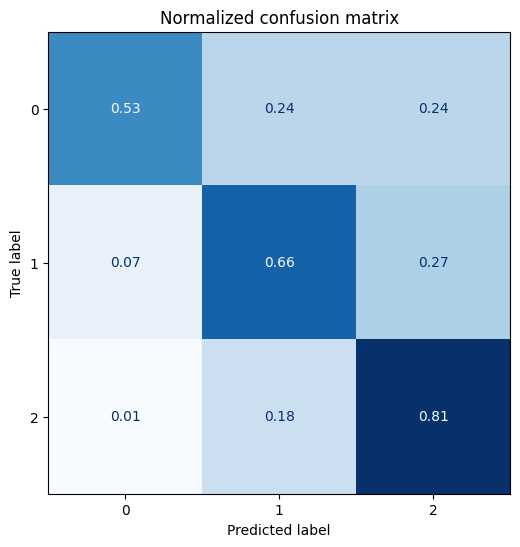

              precision    recall  f1-score   support

           2       0.50      0.53      0.51        17
           1       0.76      0.66      0.71       117
           0       0.71      0.81      0.76       110

    accuracy                           0.72       244
   macro avg       0.66      0.67      0.66       244
weighted avg       0.72      0.72      0.72       244



Map:   0%|          | 0/975 [00:00<?, ? examples/s]

Map:   0%|          | 0/244 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.059000,0.961534,0.569672,0.610011
2,0.868700,0.802391,0.655738,0.656575
3,0.706200,0.762008,0.696721,0.708311
4,0.530200,0.689911,0.717213,0.725977
5,0.402500,0.806785,0.741803,0.742093
6,0.308800,0.874428,0.778689,0.777273
7,0.250800,0.823356,0.766393,0.768256


best model:  /content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/study1/study1_answer_task_train_and_eval_2/checkpoint-124


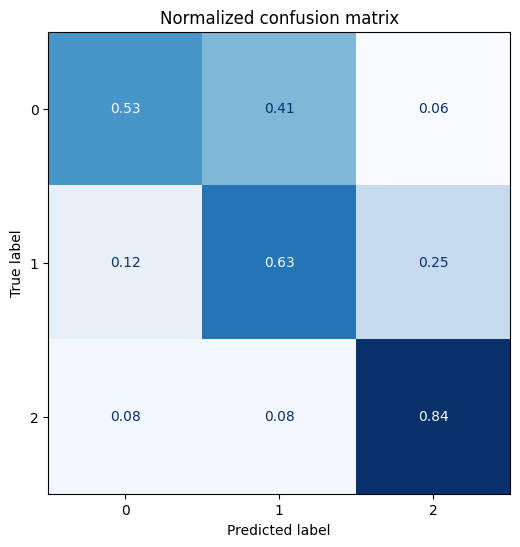

              precision    recall  f1-score   support

           1       0.28      0.53      0.37        17
           0       0.82      0.63      0.71       117
           2       0.75      0.84      0.79       110

    accuracy                           0.72       244
   macro avg       0.62      0.67      0.63       244
weighted avg       0.75      0.72      0.73       244



Map:   0%|          | 0/975 [00:00<?, ? examples/s]

Map:   0%|          | 0/244 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.074300,1.016753,0.581967,0.581431
2,0.879200,0.905281,0.635246,0.640525
3,0.685800,0.966765,0.635246,0.625174
4,0.508500,0.897592,0.692623,0.686469
5,0.411500,0.900138,0.758197,0.756741
6,0.327100,1.066198,0.766393,0.757283
7,0.236700,1.121825,0.762295,0.754038


best model:  /content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/study1/study1_answer_task_train_and_eval_3/checkpoint-124


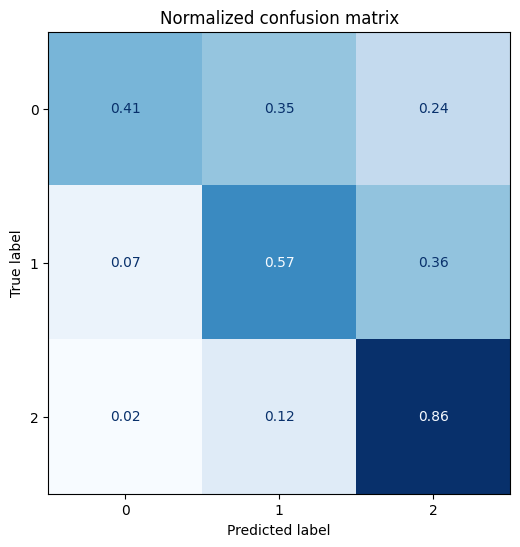

              precision    recall  f1-score   support

           2       0.41      0.41      0.41        17
           1       0.78      0.57      0.66       117
           0       0.67      0.86      0.76       110

    accuracy                           0.69       244
   macro avg       0.62      0.62      0.61       244
weighted avg       0.71      0.69      0.69       244



Map:   0%|          | 0/976 [00:00<?, ? examples/s]

Map:   0%|          | 0/243 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.063900,0.987706,0.530864,0.544717
2,0.875800,0.925624,0.674897,0.677024
3,0.729700,0.875129,0.641975,0.638556
4,0.602500,0.942271,0.744856,0.741712
5,0.412600,0.827339,0.744856,0.747715
6,0.323400,0.940765,0.802469,0.798132
7,0.247400,0.941353,0.781893,0.780521
8,0.185200,1.089556,0.769547,0.762742


best model:  /content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/study1/study1_answer_task_train_and_eval_4/checkpoint-155


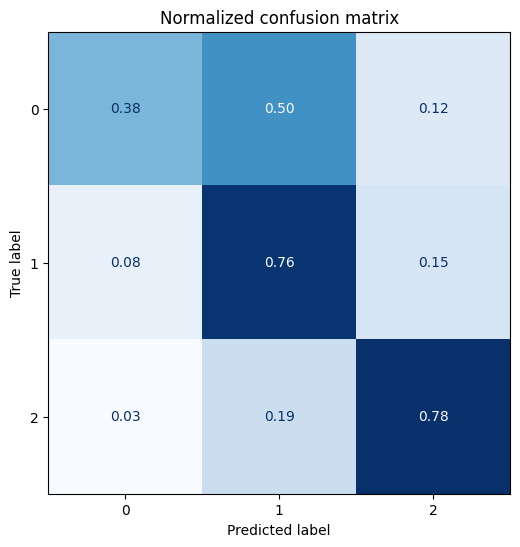

              precision    recall  f1-score   support

           2       0.32      0.38      0.34        16
           1       0.76      0.76      0.76       118
           0       0.81      0.78      0.79       109

    accuracy                           0.74       243
   macro avg       0.63      0.64      0.63       243
weighted avg       0.75      0.74      0.75       243



In [ ]:
MODEL_OUTPUT_DIR = "/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/model/study1/study1_answer_task_train_and_eval"
MODEL_NAME = "cl-tohoku/bert-base-japanese"
#BATCH_SIZE = 128#学習は早いが、精度が終わっているため、一旦バッチサイズを落とす（2023/7/25, 8:52）
BATCH_SIZE = 32

RESULT_OUTPUT_DIR_BASE = "/content/drive/MyDrive/Colaboratory/Work/sst_auto_scoring/result/study1/study1_answer_task_train_and_eval/"

#現在のfoldを管理する
for CUR_FOLD_IDX in range(NUM_FOLDS):
  #config関数から呼び出し
  cur_lc = load_config(CUR_FOLD_IDX)
  cur_config = cur_lc.return_config()

  #モデルとトークナイザの初期化
  model, tokenizer = load_bert_model_and_tokenizer()

  #データセットの用意
  dataset_train_encoded, dataset_test_encoded, data_train, data_test = create_dataset(data_basic_unique_with_folds)

  #Trainerのconfig周り
  #TrainingArgumentsの準備
  #ref: https://dev.classmethod.jp/articles/huggingface-usage-early-stopping/
  #ref: https://stackoverflow.com/questions/62525680/save-only-best-weights-with-huggingface-transformers
  training_args = TrainingArguments(
      output_dir=MODEL_OUTPUT_DIR + "_" + str(CUR_FOLD_IDX),
      num_train_epochs=10,
      learning_rate=2e-5,
      per_device_train_batch_size=BATCH_SIZE,
      per_device_eval_batch_size=BATCH_SIZE,
      weight_decay=0.01,
      save_strategy="epoch",#4/4まで; noにして, どうなるかを確認する->load_best_model_at_endと重複するからnoはダメらしい
      evaluation_strategy="epoch",
      disable_tqdm=False,
      logging_steps=cur_config["logging_steps"],
      push_to_hub=False,
      log_level="error",
      label_names=['labels'],
      load_best_model_at_end=True,
      save_total_limit=1,
  )

  # Trainerの定義
  trainer = CustomTrainer(
      model=model,
      args=training_args,
      compute_metrics=compute_metrics,
      train_dataset=dataset_train_encoded,
      eval_dataset=dataset_test_encoded,
      tokenizer=tokenizer,
      callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
  )

  # トレーニング実行
  trainer.train()

  #trainerのbestモデルの場所を書く
  print("best model: ", trainer.state.best_model_checkpoint)

  #モデルの保存を明示的に書く
  trainer.save_model()

  #評価する
  preds_output = trainer.predict(dataset_test_encoded)
  y_preds = np.argmax(preds_output.predictions, axis=1)
  y_valid = np.array(data_test["labels"])
  data_test["pred"] = y_preds

  #評価結果を保存するためのディレクトリの作成
  result_output_dir = RESULT_OUTPUT_DIR_BASE + "Fold" + str(CUR_FOLD_IDX) + "/"
  os.makedirs(result_output_dir)

  #confusion_matrixの表示と保存
  plot_confusion_matrix(data_test["pred"], data_test["labels"], result_output_dir)

  #classification_reportの表示と保存
  categories = data_test['labels'].unique().tolist()
  categories = list(map(str, categories))
  classification_report_txt = classification_report(y_valid, y_preds, target_names=categories)
  print(classification_report_txt)

  with open(result_output_dir + "classification_report.txt", "w") as output_file:
    output_file.write(classification_report_txt)

  #train_dataとtest_dataの出力
  data_test.to_csv(result_output_dir+"data_test.csv", index=False)
  data_train.to_csv(result_output_dir+"data_train.csv", index=False)

  #全て初期化する
  #->ここはデータ管理の都合うまくいかないので、コメントアウトして残す(4/3)
  # del dataset_train_encoded, dataset_test_encoded, training_args, trainer, cur_lc, cur_config, model